# Main Pipeline for Single-cell IC analysis (IO / RH / CH / SCH)
---
## How to Run
1) Install packages (one-liner)
   ```bash
   pip install numpy pandas matplotlib seaborn scikit-learn
   ```
   *(Your project also uses `plots_with_stats`, `get_index`, `batch_process`, `io_secondary_properties` — keep them alongside this script.)*
2) Put your data under **main_path** (see below). The **data contract** is enforced upstream by your code:
   - **Folder index** is derived from folder names; `_` splits conditions.
   - **One file per cell**; a file **can have more than one block**.
   - **Channels**: data (Vm) = **0**, stim = **1**.
   - **Units**: Vm **mV**, I **pA**, time **ms**, Rin **MΩ**, C **pF**, G **nS**.
   - **Tags**: `io_start/io_stop`, `rh_start/rh_stop`, `ch_start/ch_stop`, `sch_start/sch_stop`.
   - **Spike prominence** = **25** for all cells.
   - **Stim correction** = **1000** for all cells.
3) **First run:** execute cells **one-by-one** (this script creates output folders and a first-run flag). After that, you can **Run All**.
4) **Outputs** (created under `FIG_ROOT` and `EXPORT_ROOT`):
   - Every plot is exported as **SVG + PNG** and the **exact plotted data as CSV**.
   - A small meta JSON is also written per figure with parameters.

---

### Load Imports ###
*(Kept minimal; analysis logic unchanged)*

In [1]:
# Built-in
import os
import json
from pathlib import Path
from datetime import datetime

# Scientific and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Custom / Local (unchanged)
from plots_with_stats import group_comparison_plot
from get_index import StimEventIndexer
from batch_process import BatchProcess
from io_secondary_properties import (
    get_basic_properties,
    get_io_properties,
    get_waveform_properties
)

# Plot parameters
mpl.rcParams.update({'font.size': 14})
sns.set(style="whitegrid", font_scale=1.5)

print('All Imports Loaded')

All Imports Loaded


## Central Config & First-Run Guard
- Keep your existing variables; only add figure/export roots and a helper flag.

In [2]:
# ================= USER SETTINGS =================
main_path  = r"R:\Kenny\data for analysis\projection-specific resonance\sch"                    # Root path for data
stim_types = ['sch']  #['io', 'rh', 'ch', 'sch']                                                  # Stimulation protocols
analyzed_path    = r'R:\Kenny\data for analysis\projection-specific resonance\sch\analyzed'     # Folder with analyzed data
data_ch    = 0                                                                          # Voltage channel index
stim_ch    = 1                                                                          # Stimulus/current channel index
sep        = '_'                                                                        # Folder name delimiter
output_csv = os.path.join(main_path, 'index.csv')                                       # Index save location
firing_rate_threshold = 60                                                              # Hz, threshold for excluding fast spiking cells
stim_correction = 1000                                                                  # to make stim to pA
data_correction = 100                                                                  # to make data to mV
spike_detection_threshold = 40                                                          # spike detection prominence
njobs       = 1                                                                         # Number of parallel jobs
# ================================================

# Figure/Export roots (added)
FIG_ROOT = Path(analyzed_path) / 'figures'
EXPORT_ROOT = Path(analyzed_path) / 'exports'
FIG_ROOT.mkdir(parents=True, exist_ok=True)
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)

# First-run flag
FIRST_RUN_FLAG = Path(analyzed_path) / '.first_run_complete'

## Save Helpers (minimal, reused everywhere)
Every plot saves: **.png**, **.svg**, **.csv**, and optional **.meta.json** under `figures/<section>/`.

In [3]:
def _ensure_section(section: str) -> Path:
    p = FIG_ROOT / section
    p.mkdir(parents=True, exist_ok=True)
    return p


def save_plot_and_data(section: str, name: str, df: pd.DataFrame, fig: plt.Figure, params: dict | None = None):
    sec = _ensure_section(section)
    base = sec / name
    # CSV of the plotted data
    if df is not None:
        df.to_csv(f"{base}.csv", index=False)
    # Meta
    if params:
        with open(f"{base}.meta.json", "w") as f:
            json.dump(params, f, indent=2, default=str)
    # Figures
    fig.savefig(f"{base}.png", dpi=150, bbox_inches='tight')
    fig.savefig(f"{base}.svg", bbox_inches='tight')
    # plt.close(fig)


def stamp_run_metadata():
    meta = {
        'timestamp': datetime.now().isoformat(timespec='seconds'),
        'main_path': str(main_path),
        'analyzed_path': str(analyzed_path),
        'stim_types': stim_types,
        'stim_correction': stim_correction,
        'spike_detection_threshold': spike_detection_threshold,
    }
    with open(EXPORT_ROOT / 'run_metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)

## First Run
- Creates folders, writes metadata, and sets a flag. **Run this cell on the very first pass.**

In [4]:
indexer = StimEventIndexer(main_path, stim_types, data_ch, stim_ch, sep)
event_df = indexer.build_event_index()
event_df.to_csv(output_csv, index=False)

# Summary
total_files  = event_df['file_name'].nunique() if not event_df.empty else 0
total_events = len(event_df)
print(f"📁 Indexed {total_files} files, found {total_events} stim events.")
try:
    display(event_df)
except Exception:
    print(event_df.head())

📁 Indexed 20 files, found 20 stim events.


,file_path,file_name,stim_type,block,start_sample,stop_sample,data_ch,stim_ch,fs,condition_0
0,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla001_1_8_24.adicht,sch,0,20601,40500,0,1,1000,bnst
1,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla003_1_10_24.adicht,sch,0,38161,58090,0,1,1000,bnst
2,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla004_1_10_24.adicht,sch,0,100181,120200,0,1,1000,bnst
3,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla005_1_17_24.adicht,sch,0,10171,30090,0,1,1000,bnst
4,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla007_1_17_24.adicht,sch,0,123821,143800,0,1,1000,bnst
5,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla008_1_17_24.adicht,sch,0,30921,50820,0,1,1000,bnst
6,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla009_1_18_24.adicht,sch,0,33641,53600,0,1,1000,bnst
7,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla010_1_25_24.adicht,sch,0,84751,104701,0,1,1000,bnst
8,r:\kenny\data for analysis\projection-specific...,gcampbnst-bla011_1_25_24.adicht,sch,0,2141,22100,0,1,1000,bnst
9,r:\kenny\data for analysis\projection-specific...,gcampnacc-bla001_1_10_24.adicht,sch,0,107641,127580,0,1,1000,nac


### 2. Extract properties for all four protocols: ['io', 'rh', 'ch', 'sch']
*(Logic unchanged; ensures `stim_correction` and `prominence` are passed.)*

In [5]:
index_csv   = os.path.join(main_path, "index.csv")
analyzed_dir = os.path.join(main_path, 'analyzed')

idx_df = pd.read_csv(index_csv)
processor = BatchProcess(
   main_path, idx_df,
   njobs=njobs,
   stim_correction=stim_correction,
   data_correction=data_correction,
   prominence=spike_detection_threshold
)
processor.run_all(analyzed_dir, stim_types)

sch: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]

✅ All protocols processed.


### 9–12. Chirp & Short-Chirp — normalize, band, deltas (all plots saved + CSV)

In [6]:
stim_types_ch = ['sch']#['ch', 'sch']
metrics = {'ch': 'impedance', 'sch': 'spike_count'}
file_paths = {s: os.path.join(analyzed_path, s, 'features.csv') for s in stim_types_ch}
freq_bins = (3, 6, 12, 15, 30, 60)

# Containers
dfs = {}
dfs_binned_raw = {}
dfs_binned_norm = {}
deltas_raw = {}
deltas_norm = {}

# Deltas helper
def compute_deltas(group, y):
    bp = group.set_index('freq_bins')[y]
    return pd.Series({
        'delta_3-6__6-12':   bp.get(pd.Interval(3, 6),  np.nan) - bp.get(pd.Interval(6, 12), np.nan),
        'delta_15-30__3-6':  bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(3, 6), np.nan),
        'delta_15-30__6-12': bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(6, 12), np.nan),
    })

# Process CH and SCH
for stim in stim_types_ch:
    metric = metrics[stim]

    # Load and clean
    df = pd.read_csv(file_paths[stim])
    df = df.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
    try:
        df = df[~df['cell_id'].isin(to_exclude)].copy()
    except Exception:
        pass

    # Remove zero-spike cells if needed
    if metric == 'spike_count':
        total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
        df = df[total > 0]

    # Normalize per cell×treatment
    total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
    norm_col = f'norm_{metric}'
    df[norm_col] = df[metric] / total

    # Checks
    check = df.groupby(['cell_id', 'treatment'])[norm_col].sum().reset_index(name='sum_norm')
    print(f"--- {stim.upper()} normalization check --- min={check['sum_norm'].min():.4f} max={check['sum_norm'].max():.4f}")

    # Bin frequencies
    df['freq_bins'] = pd.cut(df['freq'], freq_bins)

    dfs[stim] = df

    # Binned RAW
    df_binned_raw = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[metric]
        .mean().reset_index()
    )
    dfs_binned_raw[stim] = df_binned_raw

    deltas_raw[stim] = (
        df_binned_raw.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=metric)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

    # Binned NORM
    df_binned_norm = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[norm_col]
        .mean().reset_index()
    )
    dfs_binned_norm[stim] = df_binned_norm

    deltas_norm[stim] = (
        df_binned_norm.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=norm_col)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

--- SCH normalization check --- min=1.0000 max=1.0000


C:\Users\pante\AppData\Local\Temp\ipykernel_8172\750089967.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_deltas, y=metric)
C:\Users\pante\AppData\Local\Temp\ipykernel_8172\750089967.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_deltas, y=norm_col)


#### 9. Raw metric vs frequency

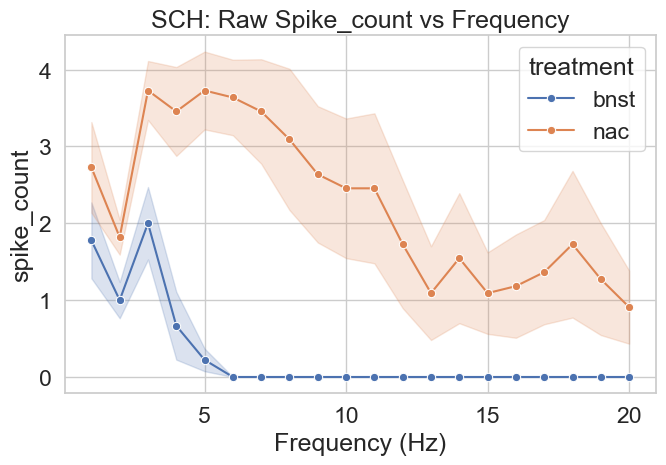

In [7]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=dfs[stim], x='freq', y=metric, hue='treatment', errorbar='se', marker='o', ax=ax)
    ax.set_title(f'{stim.upper()}: Raw {metric.capitalize()} vs Frequency')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_raw_vs_freq', dfs[stim].copy(), fig)

#### 10. Normalized metric vs frequency

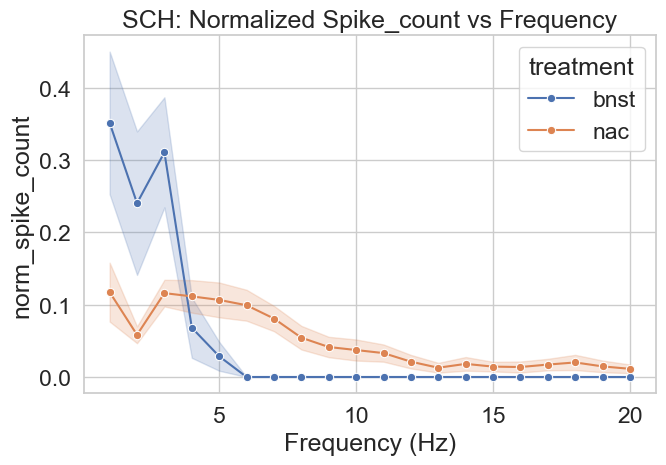

In [8]:
for stim in stim_types_ch:
    norm_col = f'norm_{metrics[stim]}'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=dfs[stim], x='freq', y=norm_col, hue='treatment', errorbar='se', marker='o', ax=ax)
    ax.set_title(f'{stim.UPPER() if hasattr(stim, "UPPER") else stim.upper()}: Normalized {metrics[stim].capitalize()} vs Frequency')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(norm_col)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_normalized_vs_freq', dfs[stim].copy(), fig, {'norm_col': norm_col})

#### 11. Binned Raw & Normalized

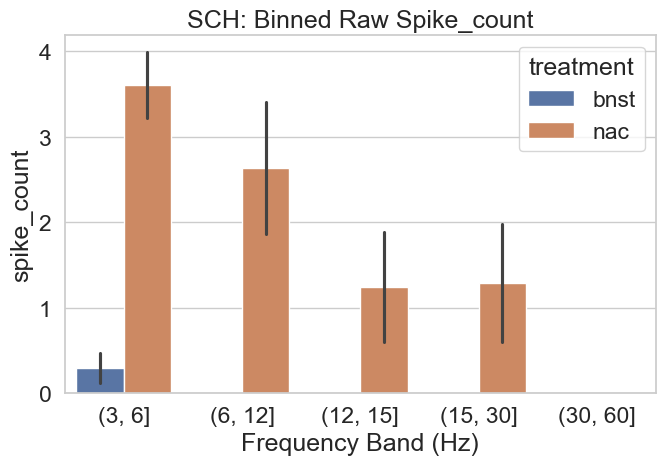

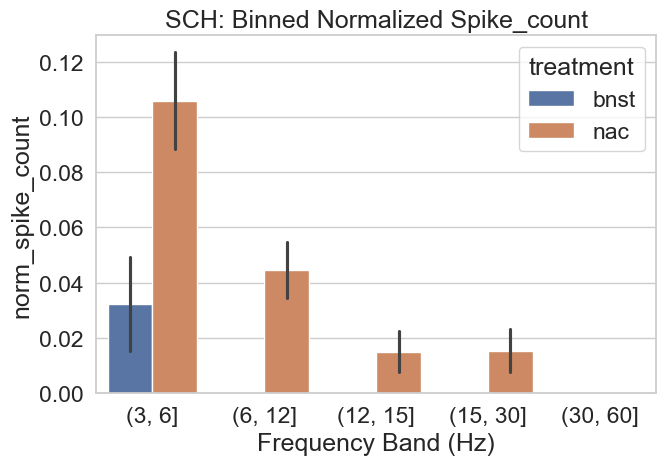

In [9]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=dfs_binned_raw[stim], x='freq_bins', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Binned Raw {metric.capitalize()}')
    ax.set_xlabel('Frequency Band (Hz)')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_binned_raw', dfs_binned_raw[stim].copy(), fig)

for stim in stim_types_ch:
    norm_col = f'norm_{metrics[stim]}'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=dfs_binned_norm[stim], x='freq_bins', y=norm_col, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Binned Normalized {metrics[stim].capitalize()}')
    ax.set_xlabel('Frequency Band (Hz)')
    ax.set_ylabel(norm_col)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_binned_normalized', dfs_binned_norm[stim].copy(), fig, {'norm_col': norm_col})

#### 12. Deltas (raw & normalized)

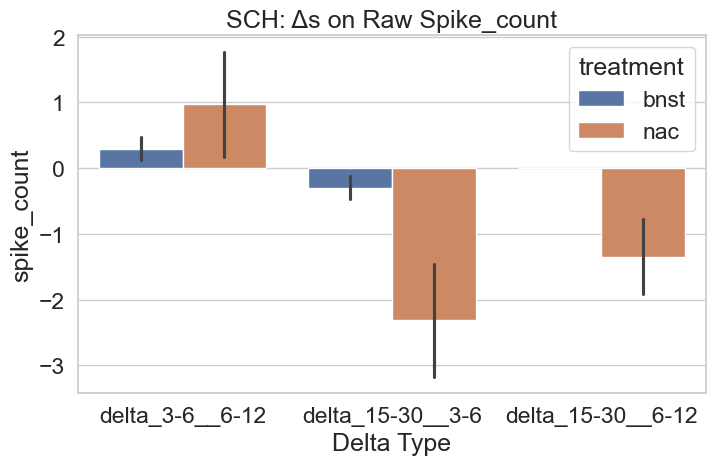

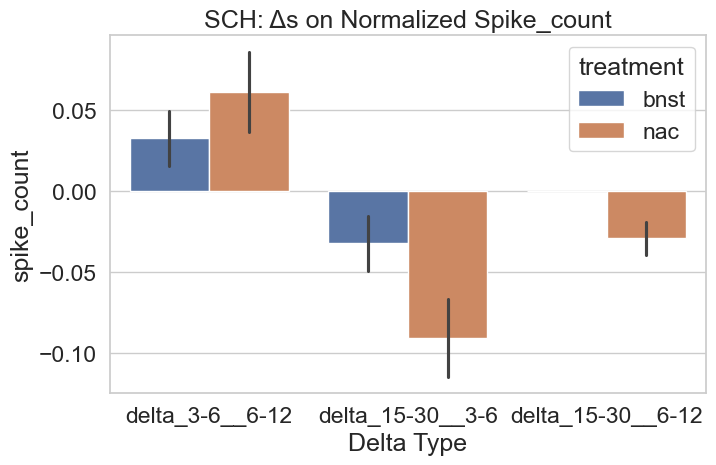

In [10]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7.5,5))
    sns.barplot(data=deltas_raw[stim], x='delta_type', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Δs on Raw {metric.capitalize()}')
    ax.set_xlabel('Delta Type')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_deltas_raw', deltas_raw[stim].copy(), fig)

for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7.5,5))
    sns.barplot(data=deltas_norm[stim], x='delta_type', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Δs on Normalized {metric.capitalize()}')
    ax.set_xlabel('Delta Type')
    ax.set_ylabel(metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_deltas_normalized', deltas_norm[stim].copy(), fig)

## Notes
- All plots now save **PNG+SVG** + the exact **CSV** used to generate them.
- Minimal code changes; your processing logic remains intact.
- Units are preserved as in your pipeline (Vm mV, I pA, time ms, Rin MΩ, etc.).